In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, f_classif
import ppscore as pps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 36

https://core.ac.uk/download/pdf/55631291.pdf

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]

# Input variables:
### bank client data:
1 - **age** (**numeric**)<br>
2 - **job** : type of job (**categorical**: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital** : marital status (**categorical**: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education** (**categorical**: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - **default**: has credit in default? (**categorical**: 'no','yes','unknown')<br>
6 - **housing**: has housing loan? (**categorical**: 'no','yes','unknown')<br>
7 - **loan**: has personal loan? (**categorical**: 'no','yes','unknown')<br>
### related with the last contact of the current campaign:
8 - **contact**: contact communication type (**categorical**: 'cellular','telephone')<br>
9 - **month**: last contact month of year (**categorical**: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day_of_week**: last contact day of the week (**categorical**: 'mon','tue','wed','thu','fri')<br>
11 - **duration**: last contact duration, in seconds (**numeric**). **DATA LEAKAGE** Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
### other attributes:
12 - **campaign**: number of contacts performed during this campaign and for this client (**numeric**, includes last contact)<br>
13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (**numeric**; 999 means client was not previously contacted)<br>
14 - **previous**: number of contacts performed before this campaign and for this client (**numeric**)<br>
15 - **poutcome**: outcome of the previous marketing campaign (**categorical**: 'failure','nonexistent','success')<br>
### social and economic context attributes
16 - **emp.var.rate**: employment variation rate - quarterly indicator (**numeric**) Probably: variation of how many people are being hired or fired due to the shifts in the conditions of the economy, - bad, + good<br>
17 - **cons.price.idx**: consumer price index - monthly indicator (**numeric**) Basically inflation, cpi < 100 == prices below base number, cpi > 100 == prices are above base number. Lets divide by 100<br>
18 - **cons.conf.idx**: consumer confidence index - monthly indicator (**numeric**) Measures how confident people are about their expected financial situation. If optimistic, consumers spend more.<br>
19 - **euribor3m**: euribor 3 month rate - daily indicator (**numeric**) Euro Interbank Offered Rate: The Euribor rates are based on the average interest rates at which a large panel of European banks borrow funds from one another. There are different maturities, ranging from one week to one year<br>
20 - **nr.employed**: number of employees - quarterly indicator (**numeric**)<br>

# Target variable:
21 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
train = pd.read_csv('../data/script_produced/train.csv')

# drop 'duration' column due to data leakage and its 'unrealistic' effect on the target variable
train = train.drop(columns='duration')

# some feature engineering

In [3]:
# I want 1 to mean neutral, not 100 so I'm dividing by 100
train.cons_price_idx /= 100


# The number of days passed since last contact for a previous campaign appears to be unimportant.
# Also, using 999 to represent NOT previously being contacted implies that they were contacted, just a lot longer ago than the others.
# What appears to be important here is that they were, or were NOT contacted.
# Because of this I'm coding this feature with 1 == contacted, 0 == NOT contacted
train.pdays = train.pdays.apply(lambda x: 0 if x == 999 else 1)


# combine the basic category together, I will also drop the 'illiterate' category when I create dummy variables
basic_ed = ['basic.4y', 'basic.6y', 'basic.9y']
train.education = train.education.apply(lambda x: 'basic' if x in basic_ed else x)

# Looking at multicollinearity

In [4]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays', 'y']
con_features = ['previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


nonexistent = train.loc[train.poutcome=='nonexistent', :]
failure = train.loc[train.poutcome=='failure', :]
success = train.loc[train.poutcome=='success', :]

nonexistent.shape, failure.shape, success.shape

((24898, 20), (2971, 20), (963, 20))

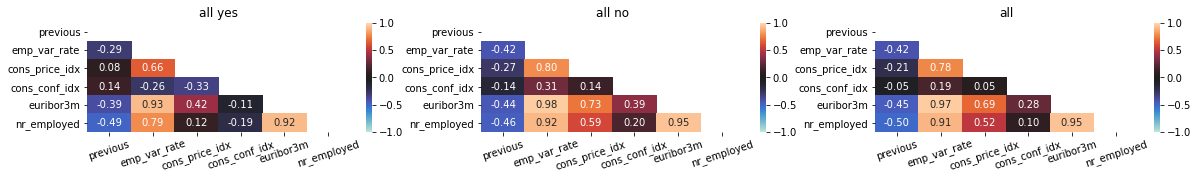

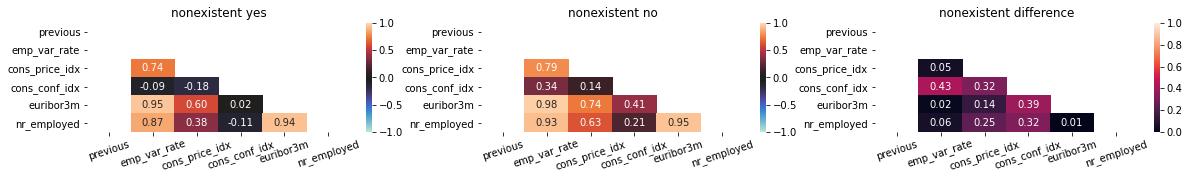

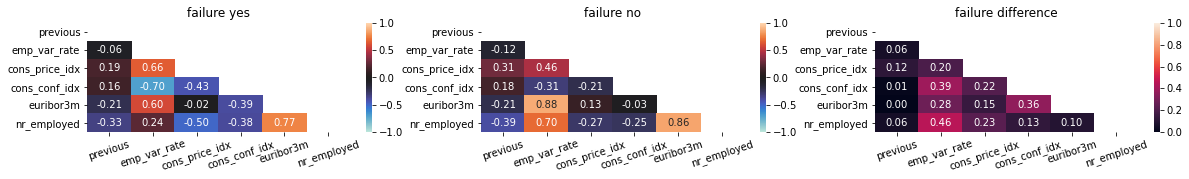

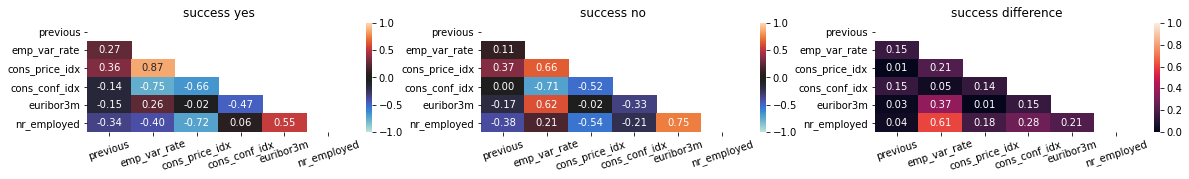

In [5]:
def collinearity(df):
    c = df.loc[:, con_features[:-1]].corr()
    mask = np.triu(np.ones_like(c, dtype=bool))

    y = df.loc[df.y=='yes', con_features[:-1]].corr()
    n = df.loc[df.y=='no', con_features[:-1]].corr()
    mask_y = np.triu(np.ones_like(y, dtype=bool))
    mask_n = np.triu(np.ones_like(n, dtype=bool))

    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,2))

    sns.heatmap(y, center=0, mask=mask_y, vmin=-1, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax1)
    ax1.set_title('all yes')
    sns.heatmap(n, center=0, mask=mask_n, vmin=-1, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax2)
    ax2.set_title('all no')
    sns.heatmap(c, center=0, mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax3)
    ax3.set_title('all')

    ax1.tick_params(axis='x', labelrotation=18)
    ax2.tick_params(axis='x', labelrotation=18)
    ax3.tick_params(axis='x', labelrotation=18);


def multiCollinearity(df, name):
    y = df.loc[df.y=='yes', con_features[:-1]].corr()
    n = df.loc[df.y=='no', con_features[:-1]].corr()
    mask_y = np.triu(np.ones_like(y, dtype=bool))
    mask_n = np.triu(np.ones_like(n, dtype=bool))

    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,2))
    sns.heatmap(y, center=0, mask=mask_y, vmin=-1, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax1)
    ax1.set_title(name+' yes')
    sns.heatmap(n, center=0, mask=mask_n, vmin=-1, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax2)
    ax2.set_title(name+' no')
    c = (n - y).abs()
    mask = np.triu(np.ones_like(c, dtype=bool))
    sns.heatmap(c, mask=mask, vmin=0, vmax=1, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax3)
    ax3.set_title(name+' difference')

    ax1.tick_params(axis='x', labelrotation=18)
    ax2.tick_params(axis='x', labelrotation=18)
    ax3.tick_params(axis='x', labelrotation=18);


collinearity(train)
multiCollinearity(nonexistent, 'nonexistent')
multiCollinearity(failure, 'failure')
multiCollinearity(success, 'success')

**previous** -> is just 0 in when **NONEXISTENT**(to be expected), some multicollinearity with **nr_employed** and **cons_price_idx**<br>
**emp_var_rate** -> highly collinear with **cons_price_idx**, **cons_conf_idx**(different between groups), **euribor3m**(some difference between groups), and **nr_employed**(different between groups)<br>
**cons_price_idx** -> highly collinear with **cons_conf_idx**(different between groups), **euribor3m**(only in **NONEXISTENT** group) and **nr_employed**(different between groups)<br>
**cons_conf_idx** -> somewhat collinear with **euribor3m**(different between groups)<br>
**euribor3m** -> highly collinear with **nr_employed**<br>

### look at categorical features with chi-square statistic

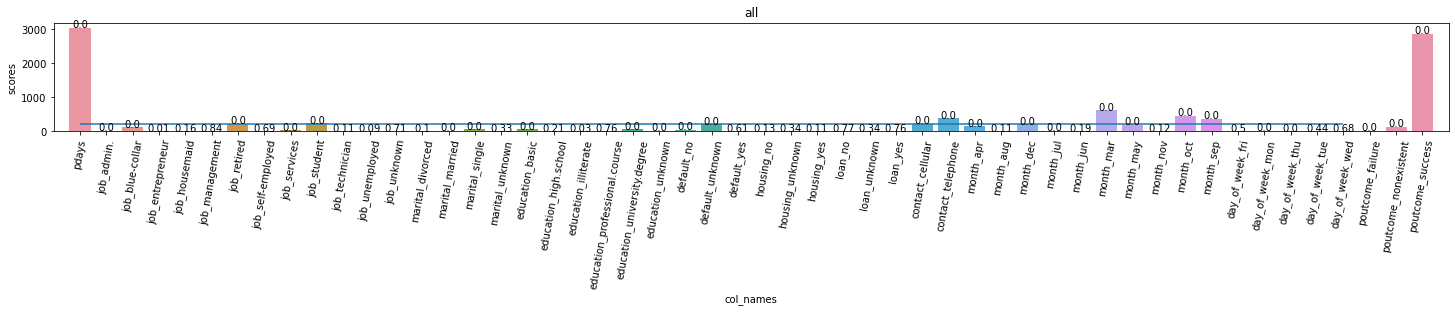

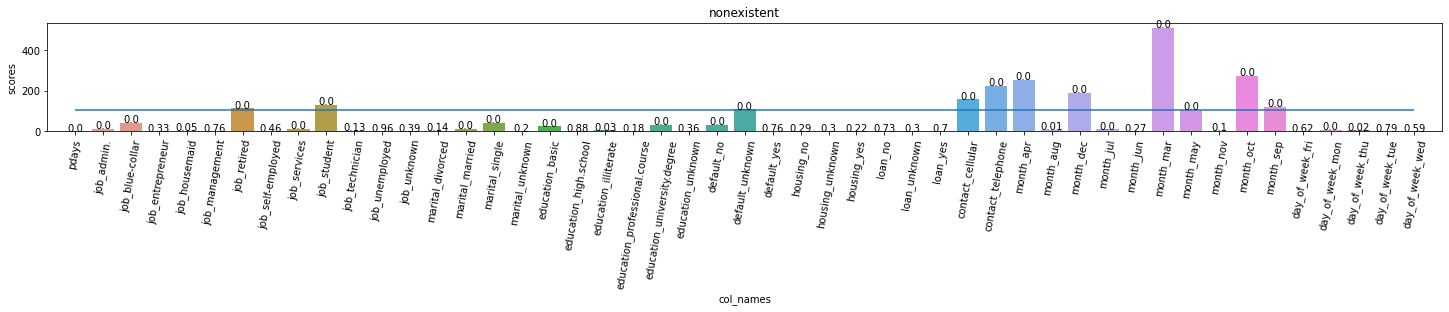

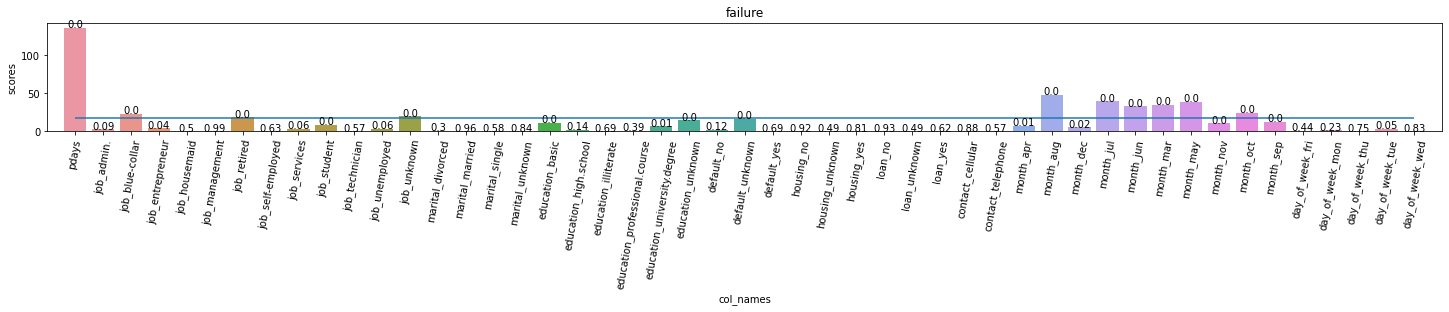

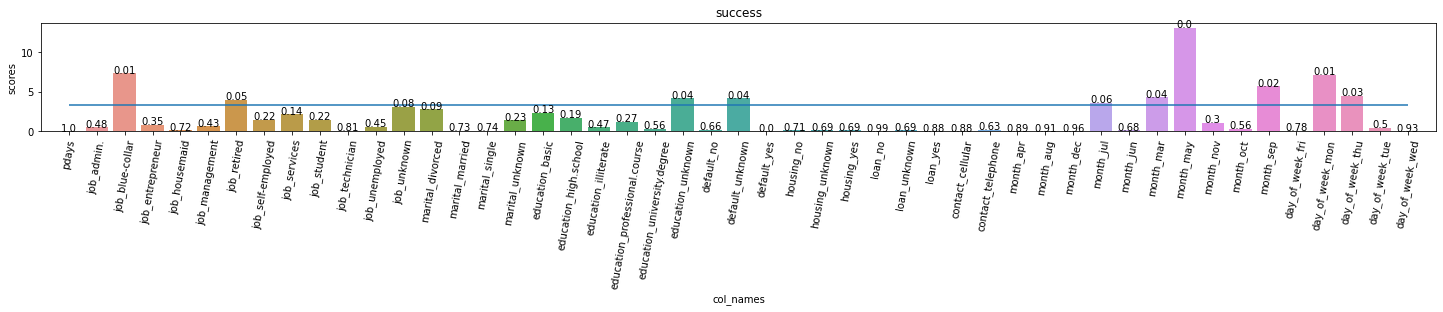

In [6]:
def dummyTrain(df):
    X = df.loc[:, cat_features]

    y = X.y
    X = X.drop(columns='y')

    X = pd.get_dummies(X)
    
    X['y'] = y
    
    return X


def makeTheseDummied(df):
    X = df.loc[:, cat_features]

    y = X.y
    X = X.drop(columns='y')

    X = pd.get_dummies(X)
    
    X['y'] = y

    c = ['poutcome_nonexistent', 'poutcome_failure', 'poutcome_success']
    nonexistent = X.loc[X.poutcome_nonexistent==1, :].drop(columns=c)
    failure = X.loc[X.poutcome_failure==1, :].drop(columns=c)
    success = X.loc[X.poutcome_success==1, :].drop(columns=c)
    
    return nonexistent, failure, success

def chiSquare(df, name):
    y = df.y
    X = df.drop(columns='y')

    chi_scores, p_values = chi2(X, y)

    sc = pd.DataFrame([[s, p, X.columns[i]] for i, (s, p) in enumerate(zip(chi_scores, p_values))], columns=['scores', 'p_values', 'col_names'])
    sc.p_values = sc.p_values.round(2)
    sc = sc.fillna(0)

    f, ax = plt.subplots(figsize=(25,2))
    sns.barplot(data=sc, x='col_names', y='scores', ax=ax)
    ax.set_title(name)
    for row in sc.itertuples():
        ax.text(row.Index, row.scores, row.p_values, color='black', ha="center")
    ax.hlines(sc.scores.quantile(.8), xmin=0, xmax=48)
    ax.tick_params(axis='x', labelrotation=80)
    ax.set_xlim(-1, 49)
    return ax


nonexistent, failure, success = makeTheseDummied(train)

all_df = dummyTrain(train)

ax = chiSquare(all_df, 'all')
ax.set_xlim(-1, 52);
chiSquare(nonexistent, 'nonexistent');
chiSquare(failure, 'failure');
chiSquare(success, 'success');

The chi-squared tests tell us if there is a relationship between the feature and the target variable that is likely to reflect a real association. Or put another way, it tells us if there is a difference between the two variables.

The top 20% (p_values < .05) from the test are:<br>
**pdays** -> useful in **failure** group<br>
**job features** -> useful in **success** mostly and some in **failure** and **nonexistent** group<br>
**education features** -> might be useful in **success** group<br>
**default_unknown** -> useful in **success** group<br>
**contact** -> useful in **nonexistent** group ONLY<br>
**month** -> looks useful in all groups<br>
**day_of_week** -> useful in **success** group

### look at continuous features with ANOVA F-value

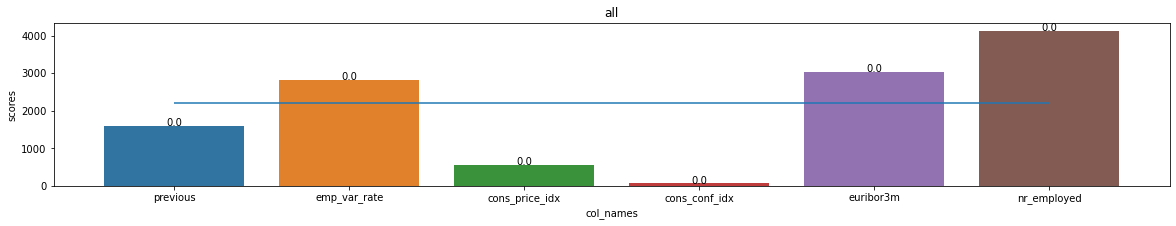

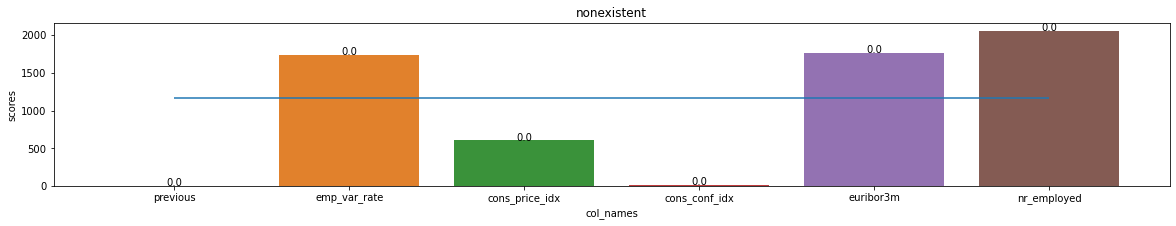

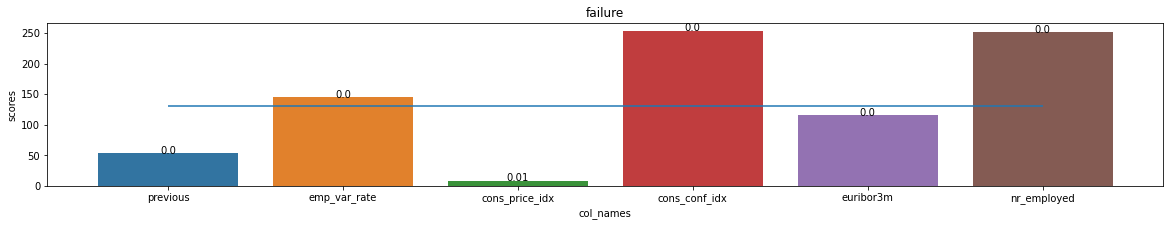

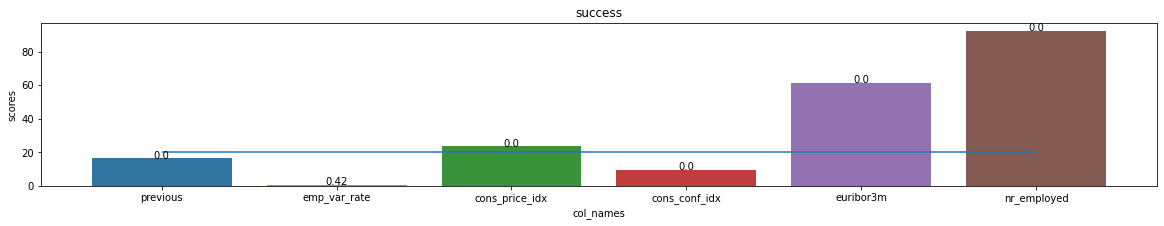

In [7]:
import warnings

def splitThese(df):
    nonexistent = df.loc[df.poutcome=='nonexistent', con_features]
    failure = df.loc[df.poutcome=='failure', con_features]
    success = df.loc[df.poutcome=='success', con_features]

    return nonexistent, failure, success


def fValue(df, name):
    y = df.y
    X = df.drop(columns='y')

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        f_scores, p_values = f_classif(X, y)

    sc = pd.DataFrame([[s, p, X.columns[i]] for i, (s, p) in enumerate(zip(f_scores, p_values))], columns=['scores', 'p_values', 'col_names'])
    sc.p_values = sc.p_values.round(2)
    sc = sc.fillna(0)

    f, ax = plt.subplots(figsize=(20,3))
    sns.barplot(data=sc, x='col_names', y='scores', ax=ax)
    ax.set_title(name)
    for row in sc.itertuples():
        ax.text(row.Index, row.scores, row.p_values, color='black', ha="center")
    ax.hlines(sc.scores.quantile(.5), xmin=0, xmax=5)
    ax.tick_params(axis='x', labelrotation=0);


nonexistent, failure, success = splitThese(train)

fValue(train.loc[:, con_features], 'all')
fValue(nonexistent, 'nonexistent')
fValue(failure, 'failure')
fValue(success, 'success')

The top 50% (p_values < .05) from the test are:<br>
**previous** -> might be useful in **success** group<br>
**emp_var_rate** -> useful in **nonexistent** and **failure** groups<br>
**cons_price_idx** -> useful in **nonexistent** and **success** groups<br>
**cons_conf_idx** -> useful in **failure** group<br>
**euribor3m** -> useful in all groups<br>
**nr_employed** -> useful in all groups

### look at the Predictive Power Score (PPS) for all features

https://github.com/8080labs/ppscore

The score ranges from 0 (no predictive power) to 1 (perfect predictive power)

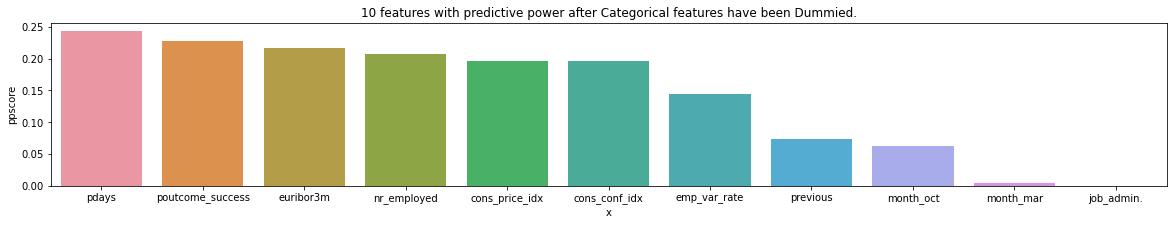

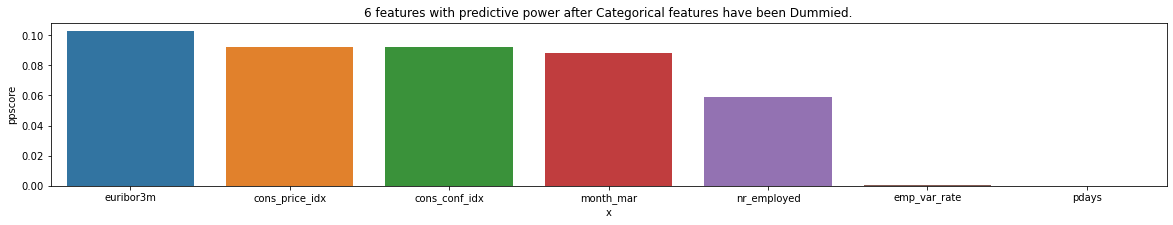

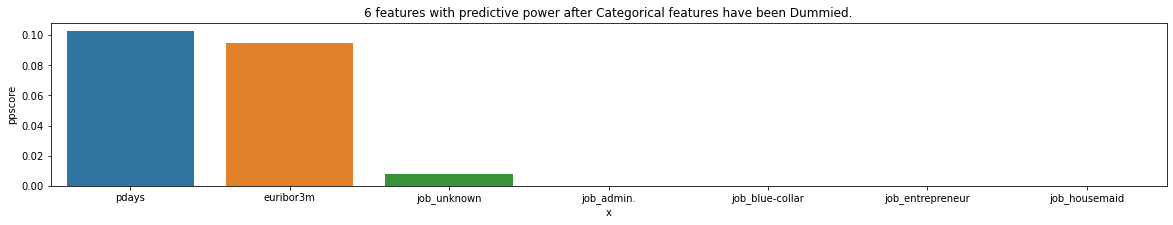

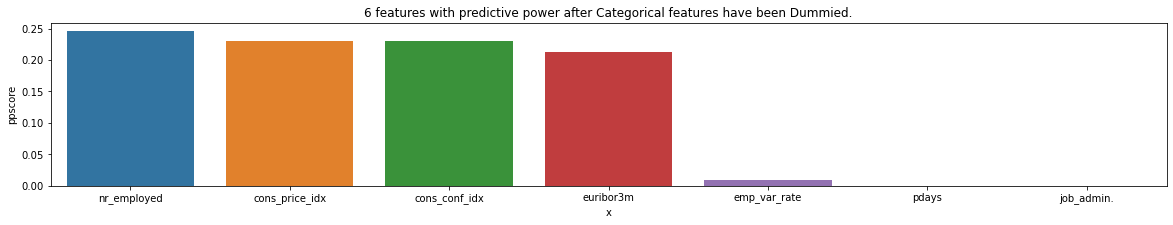

In [8]:
def dummyTrain(df):
    X = df.loc[:, cat_features]
    X = X.drop(columns='y')
    X = pd.get_dummies(X)
    X = pd.concat([X, df.loc[:, con_features]], axis=1)

    return X


def makeTheseDummied(df):
    X = df.loc[:, cat_features]
    X = X.drop(columns='y')
    X = pd.get_dummies(X)
    X = pd.concat([X, df.loc[:, con_features]], axis=1)

    c = ['poutcome_nonexistent', 'poutcome_failure', 'poutcome_success']
    nonexistent = X.loc[X.poutcome_nonexistent==1, :].drop(columns=c)
    failure = X.loc[X.poutcome_failure==1, :].drop(columns=c)
    success = X.loc[X.poutcome_success==1, :].drop(columns=c)
    
    return nonexistent, failure, success


def ppsMetrics(df, cut):
    dummied = pps.predictors(df, 'y').loc[:cut, ['x', 'ppscore', 'metric']]

    f, ax = plt.subplots(figsize=(20,3))
    sns.barplot(data=dummied, x='x', y='ppscore', ax=ax)
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_title(f'{cut} features with predictive power after Categorical features have been Dummied.')
    return ax


nonexistent, failure, success = makeTheseDummied(train)

all_df = dummyTrain(train)

ax = ppsMetrics(all_df, 10)

ax = ppsMetrics(nonexistent, 6)
ax = ppsMetrics(failure, 6)
ax = ppsMetrics(success, 6)

For the whole dataframe:<br>
**pdays**, **poutcome_success**, **euribor3m**, **nr_employed**, **cons_price_idx**, **cons_conf_idx**, **emp_var_rate**, **previous**, **mont_oct**, **month_mar**
<br><br>

For the others sets:<br>
**pdays** -> kind of good for **failures** group<br>

**euribor3m** -> shows up in all, best in **success** group<br>
**cons_price_idx** -> good in **nonexistent** and **success** groups<br>
**cons_conf_idx** -> good in **nonexistent** and **success** groups<br>
**nr_employed** -> best in **success** and okay **nonexistent** groups<br>

**CAUTION**<br>
**month_mar** -> shows up in **nonexistent**, but no where else, makes me suspicious, like database/code bug occured during that month maybe

## Features we will consider for the model, some of which will probably get trashed

## get rid of one of the dummy variables to help with overfitting

**job** -> drop **job_unknown**<br>
**marital** -> drop **marital_unknown**<br>
**education** -> drop **education_illiterate**<br>
**default** -> drop **default_yes**<br>
**housing** -> drop **housing_unknown**<br>
**loan** -> drop **loan_unknown**<br>
**contact** -> drop **contact_telephone**<br>
**month** -> drop **month_dec**<br>
**day_of_week** -> drop **day_of_week_fri**<br>
**poutcome** -> drop **poutcome_nonexistent**<br>

In [9]:
cols_to_use = [
    'pdays',
    'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
    'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 
    'marital_divorced', 'marital_married', 'marital_single',
    'education_basic', 'education_high.school', 'education_professional.course', 'education_university.degree', 'education_unknown',
    'default_no', 'default_unknown',
#     'housing_no', 'housing_yes',
#     'loan_no', 'loan_yes',
    'contact_cellular',
    'month_apr', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
    'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
    'poutcome_failure', 'poutcome_success',
    'previous',
    'emp_var_rate',
    'cons_price_idx',
    'cons_conf_idx',
    'euribor3m',
    'nr_employed',
    'y'
]

all_df = all_df.loc[:, cols_to_use]
all_df.loc[all_df.y=='yes', 'y'] = 1
all_df.loc[all_df.y=='no', 'y'] = 0

all_df.head()

,pdays,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,day_of_week_wed,poutcome_failure,poutcome_success,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.1,0.93200,-42.0,4.191,5195.8,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.4,0.93918,-42.7,4.962,5228.1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.4,0.93918,-42.7,4.958,5228.1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,-0.1,0.93200,-42.0,4.076,5195.8,0


## save new csv files

In [10]:
# read in testing data JUST to feature engineer and select columns
test = pd.read_csv('../data/script_produced/test.csv')

test.cons_price_idx /= 100
test.pdays = test.pdays.apply(lambda x: 0 if x == 999 else 1)
basic_ed = ['basic.4y', 'basic.6y', 'basic.9y']
test.education = test.education.apply(lambda x: 'basic' if x in basic_ed else x)

test_dum = pd.get_dummies(test.loc[:,cat_features[:-1]])

final_test = pd.concat([test_dum, test.loc[:, con_features]], axis=1)
final_test = final_test.loc[:, cols_to_use]
final_test.loc[final_test.y=='yes', 'y'] = 1
final_test.loc[final_test.y=='no', 'y'] = 0

final_test.head()

,pdays,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,day_of_week_wed,poutcome_failure,poutcome_success,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1.1,0.93994,-36.4,4.857,5191.0,0


In [11]:
# all_df.to_csv('../data/notebook_produced_2/train.csv', index=False)
# final_test.to_csv('../data/notebook_produced_2/test.csv', index=False)